# Colony size - enlarged vs. normal 9-12 days

In [1]:
library(splines)
library(scales)
library(ggplot2)
library(sleuth)

In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [5]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [6]:
d=droplevels(subset(d,! sample %in% exclude ))

In [7]:
variable ="colony_size"
variable2 ="colony_size"
normal="normal"
alt="enlarged"
table(d[,variable])


enlarged   normal  reduced 
      13       42       14 

In [8]:
table(d[,variable])


enlarged   normal  reduced 
      13       42       14 

In [9]:
d[,variable]=factor(d[,variable],levels=c(normal,"reduced","enlarged"))
d=droplevels(subset(d,Time %in% c(9,12)))
if (!is.null(alt)) {
    d=droplevels(d[d[,variable] %in% c(normal,alt),])
}
table(d[,variable])


  normal enlarged 
      18        6 

In [10]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  24 

In [11]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=as.character(paste(m$GENEID,m$class,sep="."))
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [12]:
so=sleuth_prep(d, target_mapping = m,aggregation_column = 'gene', 
               gene_mode = TRUE,extra_bootstrap_summary = TRUE,read_bootstrap_tpm=TRUE)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
........................
normalizing est_counts
45942 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21951 genes passed the filter
Warning message in sleuth_prep(d, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



In [13]:
options(repr.plot.width=10, repr.plot.height=5)

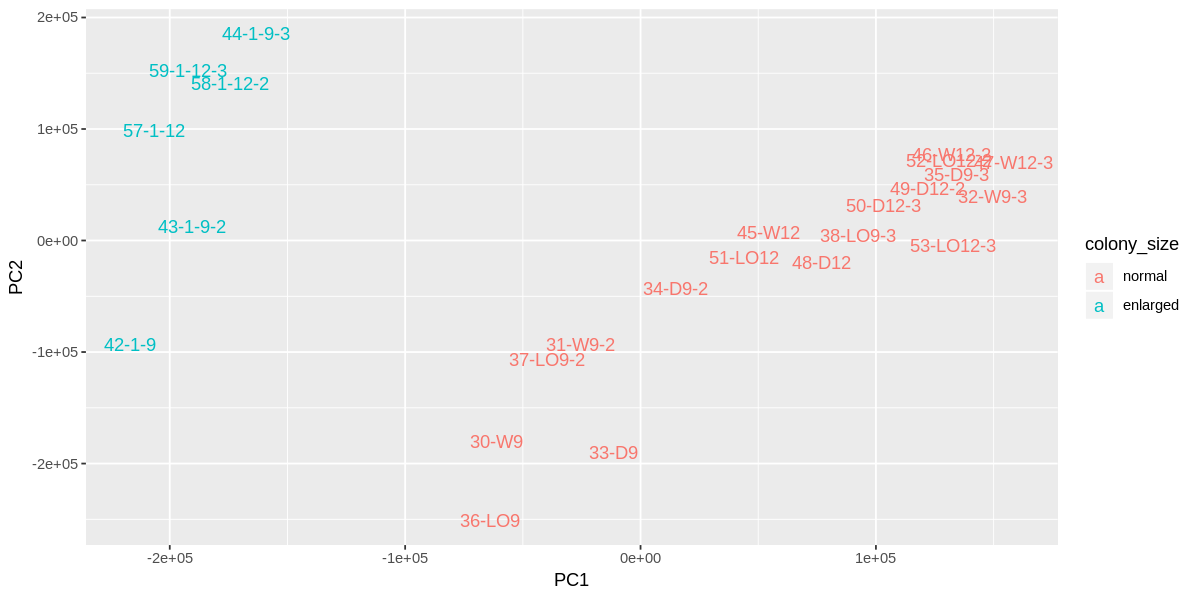

In [14]:
plot_pca(so, color_by = variable,text_labels = TRUE,units='scaled_reads_per_base')

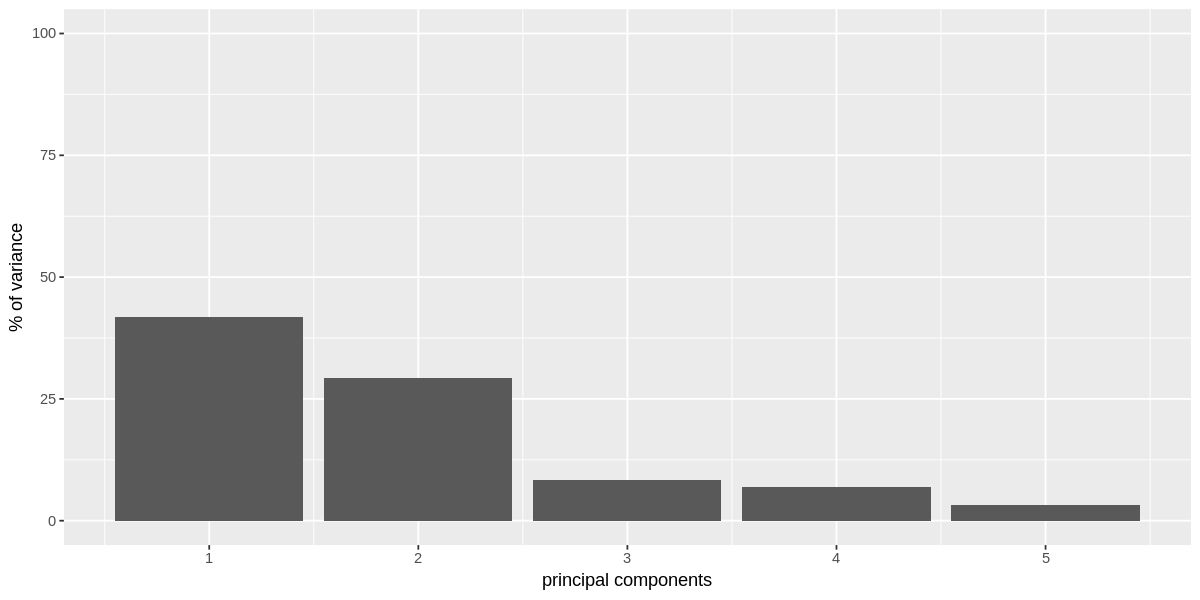

In [15]:
plot_pc_variance(so,units='scaled_reads_per_base')

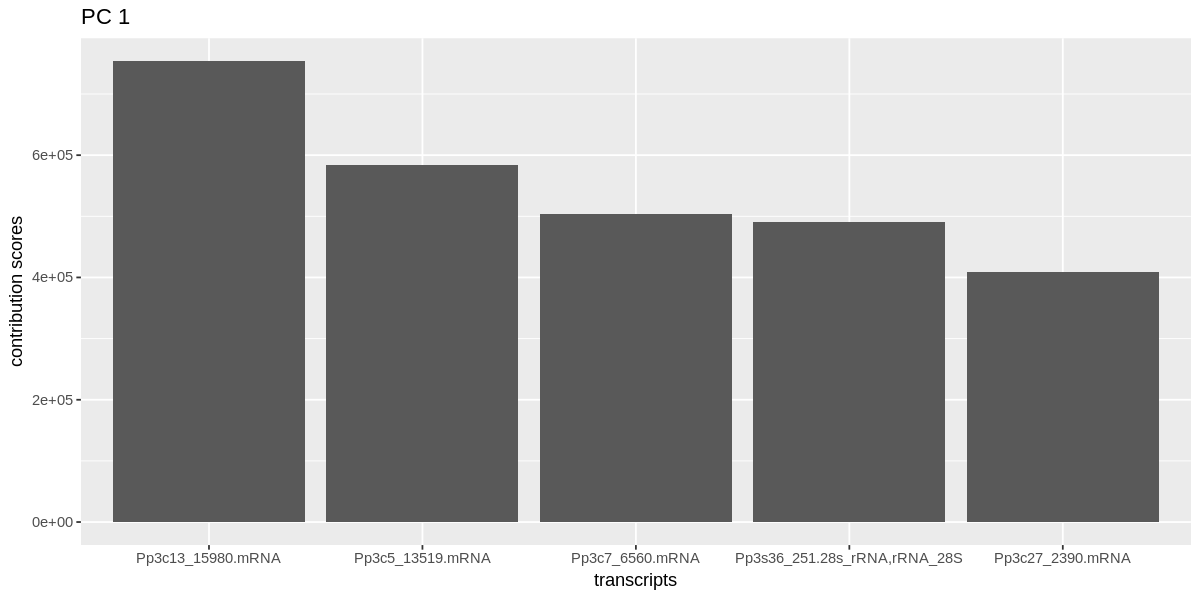

In [16]:
plot_loadings(so, pc_input = 1,units='scaled_reads_per_base')

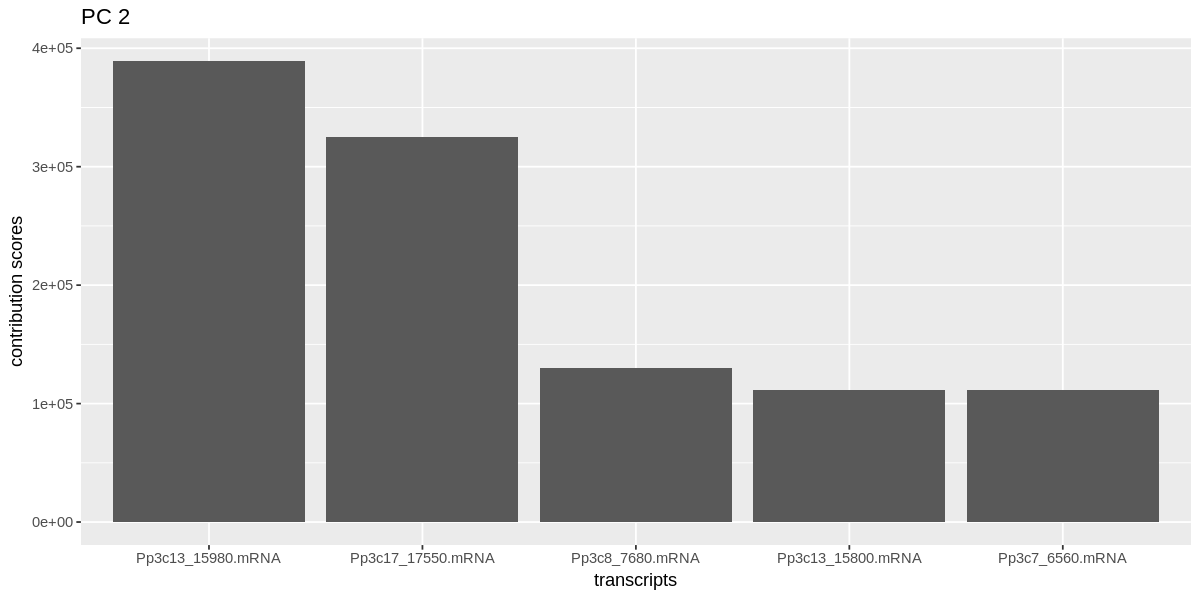

In [17]:
plot_loadings(so, pc_input = 2,units='scaled_reads_per_base')

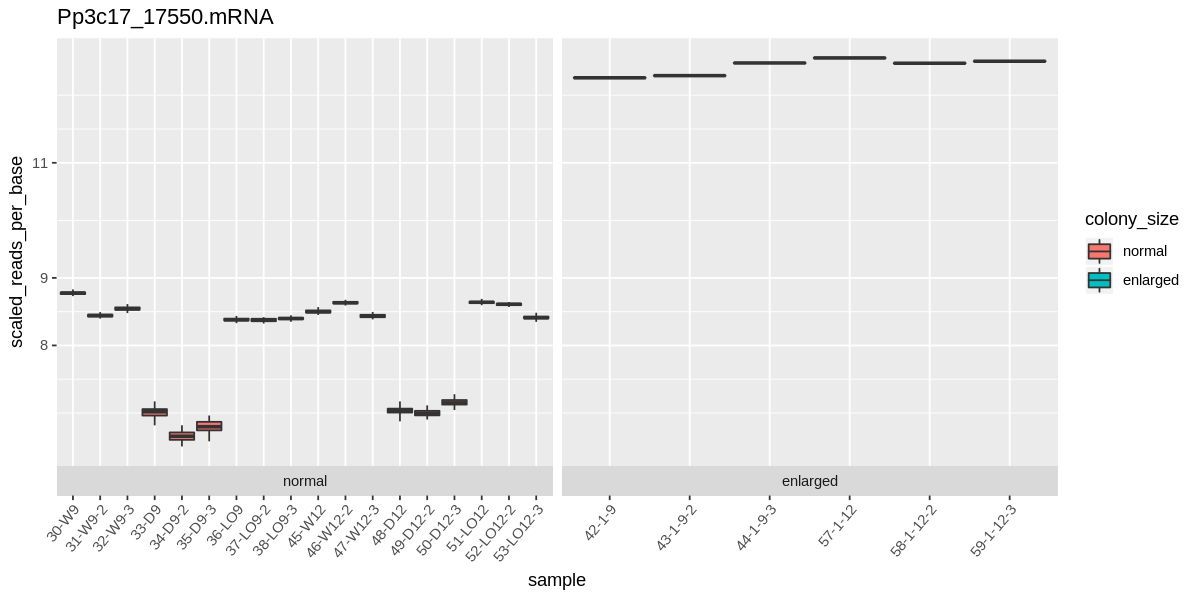

In [18]:
plot_bootstrap(so, 'Pp3c17_17550.mRNA', color_by = variable,units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [19]:
full_design <- model.matrix(as.formula(paste("~ ",variable,"+ factor(batch)",sep="")),data=d)
reduced_design <- model.matrix(formula(~  factor(batch)) ,data=d)

In [20]:
dim(full_design)
head(full_design)

[1] 24  4

,(Intercept),colony_sizeenlarged,factor(batch)2,factor(batch)3
30,1,0,0,0
31,1,0,1,0
32,1,0,0,1
33,1,0,0,0
34,1,0,1,0
35,1,0,0,1


In [21]:
dim(reduced_design)
dim(full_design)

[1] 24  3

[1] 24  4

In [22]:
so= sleuth_fit(so,reduced_design,fit_name="reduced")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [23]:
so= sleuth_fit(so, full_design, fit_name = "full")

fitting measurement error models
shrinkage estimation
3 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3s1085_40.rRNA_18S, Pp3s71_39.28s_rRNA,rRNA_28S, Pp3s745_3.rRNA_18S
computing variance of betas


In [24]:
so = sleuth_lrt(so, "reduced", "full")

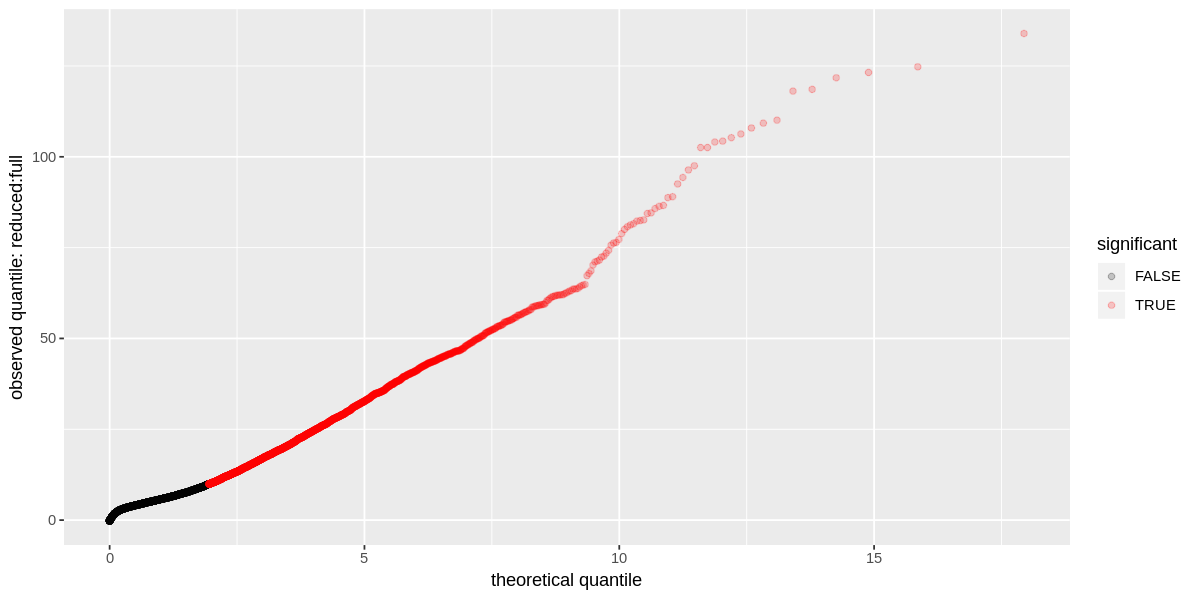

In [25]:
plot_qq(so, test = 'reduced:full', test_type = 'lrt', sig_level = 0.01)

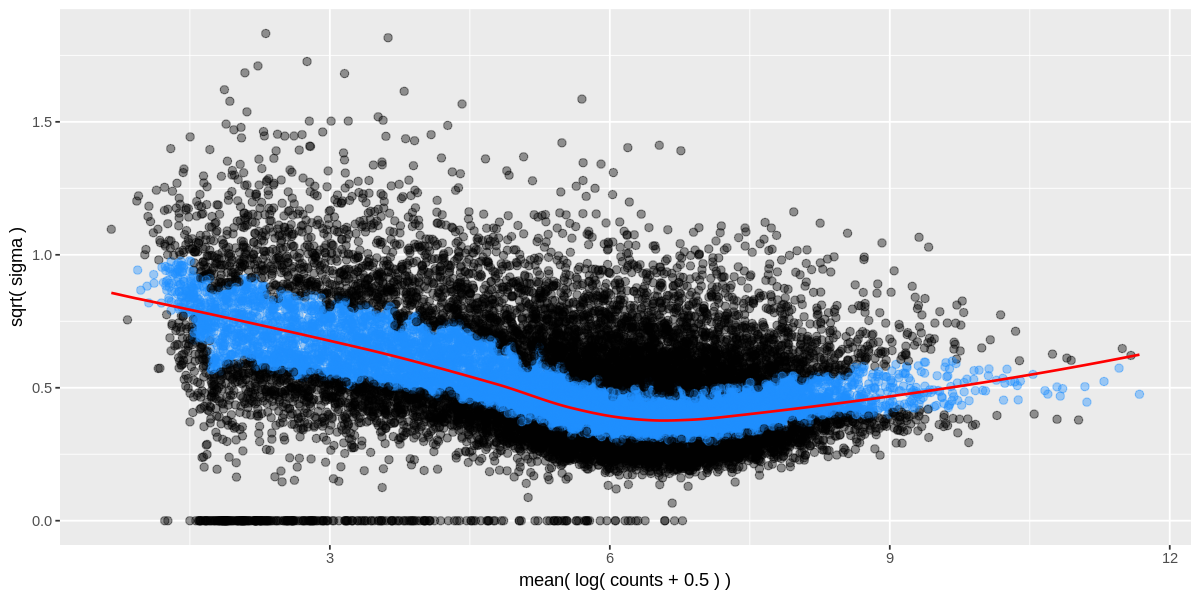

In [26]:
plot_mean_var(so,which_model="full")

In [27]:
lrt_results= sleuth_results(so, 'reduced:full', test_type = 'lrt',show_all=TRUE)
table(lrt_results$qval<0.01)


FALSE  TRUE 
18383  3568 

In [28]:
models(so)

[  reduced  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1), .Dim = c(24L, 3L), .Dimnames = list(     c("30", "31", "32", "33", "34", "35", "36", "37", "38", "42",      "43", "44", "45", "46", "47", "48", "49", "50", "51", "52",      "53", "57", "58", "59"), c("(Intercept)", "factor(batch)2",      "factor(batch)3")), assign = c(0L, 1L, 1L), contrasts = list(     "factor(batch)" = "contr.treatment")) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	factor(batch)2
 	factor(batch)3
[  full  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,  0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,  0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1

In [29]:
so=sleuth_wt(so, which_beta = colnames(full_design)[2], which_model = 'full')
tt=sleuth_results(so,colnames(full_design)[2],"wt")
tt.sig= dplyr::filter(tt, qval < 0.01)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 3376


FALSE  TRUE 
 1938  1438 

In [30]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
11180 10771 

,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,tech_var.wt,sigma_sq.wt,smooth_sigma_sq.wt,final_sigma_sq.wt
11946,Pp3c17_17550.mRNA,mRNA,mRNA,2.012212e-15,7.486452e-13,63.05298,120.78689,1,8.269127,5.252683,⋯,3.329004e-58,1.522395e-55,4.991512,0.3103494,8.269127,5.252683,0.000962116,0.43246339,0.03533077,0.4324634
10683,Pp3c16_18789.mRNA,mRNA,mRNA,8.805660e-12,9.811829e-10,46.57770,110.64030,1,2.214461,4.942098,⋯,5.511643e-28,7.377200e-26,4.591426,0.4186613,2.214461,4.942098,0.228830332,0.55991729,0.29787096,0.5599173
30268,Pp3c6_19501.mRNA,mRNA,mRNA,2.555096e-19,1.752716e-16,80.75501,97.76176,1,3.579306,4.273916,⋯,7.533984e-95,5.168078e-92,4.590199,0.2221510,3.579306,4.273916,0.065942170,0.08141331,0.15613770,0.1561377
8301,Pp3c14_2570.mRNA,mRNA,mRNA,3.154255e-04,2.667144e-03,12.97650,147.19924,1,2.923573,6.463847,⋯,1.336744e-04,1.208022e-03,3.714433,0.9724693,2.923573,6.463847,2.797698035,1.45793644,0.21718799,1.4579364
27865,Pp3c4_31690.mRNA,mRNA,mRNA,2.676074e-17,1.366105e-14,71.56990,64.25314,1,4.238174,2.872180,⋯,4.589214e-84,2.878224e-81,3.682374,0.1895522,4.238174,2.872180,0.033449003,0.12823612,0.10388301,0.1282361
16521,Pp3c2_36490.mRNA,mRNA,mRNA,1.417260e-09,7.268755e-08,36.64495,68.28363,1,4.448297,3.286543,⋯,1.484025e-17,8.374252e-16,3.449855,0.4045144,4.448297,3.286543,0.082243526,0.65409999,0.08966963,0.6541000


In [31]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [32]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"chr1545,CHR1545"
Pp3c10_13960,"CHLH1,CHLH2,chlh2,chlh1"
Pp3c10_13970,"chlh1,chlh2,CHLH2,CHLH1"
Pp3c10_14020,"RABA53,raba53"
Pp3c10_14800,"PPR_20,ppr_20"


In [33]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [34]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [35]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21951

[1] 21951

[1] 21951

[1] 21951

[1] 21951

,GENEID,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
9925,Pp3c2_27820,Pp3c2_27820.mRNA,mRNA,mRNA,5.634126e-31,1.236747e-26,133.9390,215.5590,1,4.496321,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
7938,Pp3c17_9430,Pp3c17_9430.mRNA,mRNA,mRNA,5.705468e-29,6.262036e-25,124.7733,205.6731,1,4.368850,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR11439//PTHR11439:SF180 - GAG-POL-RELATED RETROTRANSPOSON // SUBFAMILY NOT NAMED (1 of 1),NA,NA,NA
21816,Pp3s44_20,Pp3s44_20.mRNA,mRNA,mRNA,1.245361e-28,9.112306e-25,123.2244,194.7028,1,4.233435,⋯,true,true,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
7185,Pp3c17_10030,Pp3c17_10030.mRNA,mRNA,mRNA,2.608974e-28,1.431740e-24,121.7571,227.0949,1,4.818505,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
3911,Pp3c13_120,Pp3c13_120.mRNA,mRNA,mRNA,1.306286e-27,5.734857e-24,118.5617,221.5444,1,4.778867,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
4498,Pp3c13_7860,Pp3c13_7860.mRNA,mRNA,mRNA,1.671048e-27,6.113529e-24,118.0732,167.0148,1,3.874520,⋯,true,false,protein_coding_gene,false,NA,pdef,K10743 - ribonuclease H2 subunit A (RNASEH2A) (1 of 1),NA,NA,NA


In [36]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7467
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
class.lrt,mRNA
TYPE.lrt,mRNA
pval.lrt,2.012212e-15
qval.lrt,7.486452e-13
test_stat,63.05298
rss,120.7869
degrees_free,1
mean_obs.lrt,8.269127


In [37]:
table(o$qval.lrt<0.01)


FALSE  TRUE 
18383  3568 

In [38]:
head(O[,c("target_id","test_stat","qval.lrt","qval.wt","b","name","superfamily","has_evidence","TAP_class","defline")],n=60)

,target_id,test_stat,qval.lrt,qval.wt,b,name,superfamily,has_evidence,TAP_class,defline
9925,Pp3c2_27820.mRNA,133.93896,1.236747e-26,0.000000e+00,-6.919290,NA,NA,true,NA,NA
7938,Pp3c17_9430.mRNA,124.77328,6.262036e-25,0.000000e+00,-6.749330,NA,NA,true,NA,PTHR11439//PTHR11439:SF180 - GAG-POL-RELATED RETROTRANSPOSON // SUBFAMILY NOT NAMED (1 of 1)
21816,Pp3s44_20.mRNA,123.22441,9.112306e-25,0.000000e+00,-6.568776,NA,NA,false,NA,NA
7185,Pp3c17_10030.mRNA,121.75714,1.431740e-24,0.000000e+00,-7.084639,NA,NA,true,NA,NA
3911,Pp3c13_120.mRNA,118.56168,5.734857e-24,0.000000e+00,-6.993601,NA,NA,true,NA,NA
4498,Pp3c13_7860.mRNA,118.07321,6.113529e-24,8.309476e-268,-6.090223,NA,NA,true,NA,K10743 - ribonuclease H2 subunit A (RNASEH2A) (1 of 1)
7933,Pp3c17_9310.mRNA,110.06694,2.970818e-22,0.000000e+00,-7.328726,NA,NA,true,NA,PF08148 - DSHCT (NUC185) domain (DSHCT) (1 of 6)
8741,Pp3c19_14410.mRNA,109.26210,3.901389e-22,2.863633e-213,-6.286377,NA,NA,true,NA,PTHR22957//PTHR22957:SF327 - TBC1 DOMAIN FAMILY MEMBER GTPASE-ACTIVATING PROTEIN // SUBFAMILY NOT NAMED (1 of 4)
21665,Pp3s128_60.mRNA,107.92651,6.803137e-22,1.955055e-198,-5.714987,NA,NA,true,NA,NA
7929,Pp3c17_9290.mRNA,106.28532,1.401523e-21,1.183144e-236,-3.640027,NA,NA,true,NA,PTHR23155//PTHR23155:SF577 - LEUCINE-RICH REPEAT-CONTAINING PROTEIN // SUBFAMILY NOT NAMED (1 of 5)


In [39]:
plot_transcript_heatmap(so, head(O, n = 25)$target_id)

In [40]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.01)[,c("target_id","test_stat","qval.lrt","qval.wt","b","Alias")]

,target_id,test_stat,qval.lrt,qval.wt,b,Alias
4481,Pp3c13_7201.pre_miRNA,17.58463,0.0003468749,0.0001433904,-0.6374187,"MI0005966,Pp3c13_7201V1.1,ppt-MIR1025,Pp3c13_7201N1.1,N1.Chr13.ncRNA.30"
8561,Pp3c18_7951.pre_miRNA,10.25967,0.0087093159,0.0238731341,0.3204369,"Pp3c18_7951V1.1,Pp3c18_7951N1.1,ppt-MIR319a,N1.Chr18.ncRNA.41,MI0003496"


In [41]:
dir.create(file.path("factors"), showWarnings = FALSE)
dir=sprintf("factors/%s.%s_vs_%s",variable2,normal,alt)
dir.create(file.path(dir), showWarnings = FALSE)

write.table(o,gzfile(paste(dir,"dge.tsv.gz",sep="/")),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile(paste(dir,"dge.full.tsv.gz",sep="/")),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)